In [ ]:
!pip install kaggle

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from xgboost import XGBClassifier
import numpy as np
from sklearn.utils import resample
import pickle

2025-11-18 14:49:17.304982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763477357.326951     118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763477357.333703     118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
from google.colab import files
files.upload()
print("done")

Saving kaggle.json to kaggle.json
done


In [ ]:
# Buat direktori jika belum ada

os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file ke direktori .kaggle

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Atur permission agar tidak terlalu terbuka

os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download rupakroy/online-payments-fraud-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
License(s): CC-BY-NC-SA-4.0
 67%|██████████████████████████▊             | 119M/178M [00:00<00:00, 1.24GB/s]
100%|████████████████████████████████████████| 178M/178M [00:00<00:00, 1.25GB/s]


In [ ]:
!unzip online-payments-fraud-detection-dataset.zip

Archive:  online-payments-fraud-detection-dataset.zip
  inflating: PS_20174392719_1491204439457_log.csv  


## Data Understanding

In [ ]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Memeriksa Type Data column

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1530544995,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


### Memeriksa Missing Value

In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Memeriksa Duplikat

In [ ]:
df.duplicated().sum()

0

### Memeriksa Data outlier

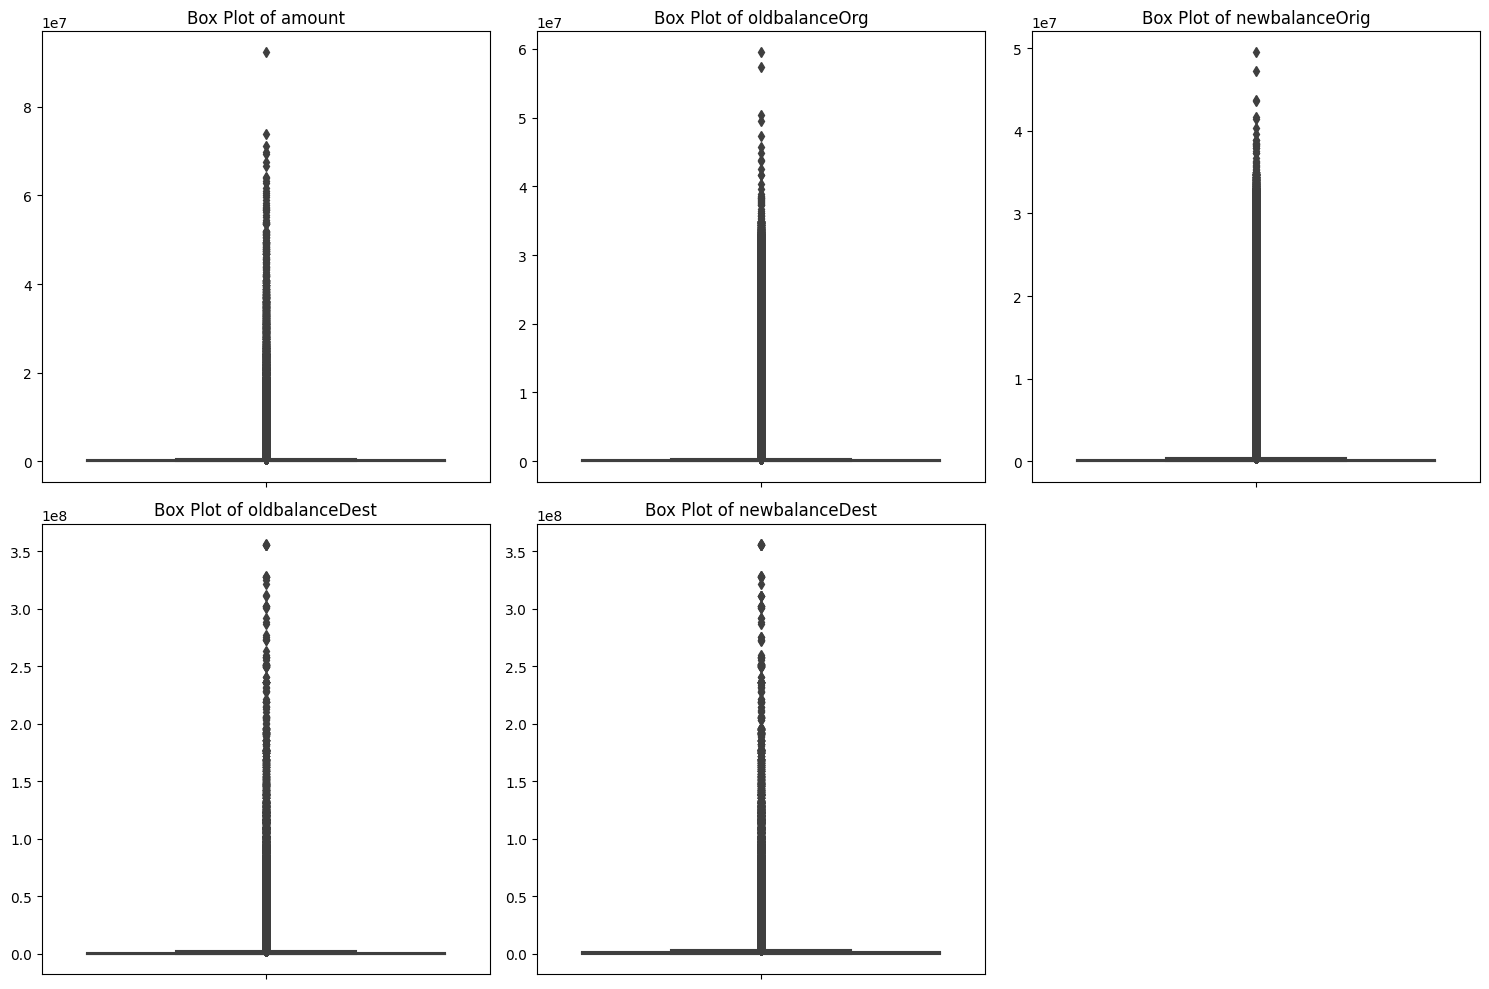

In [ ]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude 'isFraud' and 'isFlaggedFraud' from outlier detection if they are purely binary flags
# and we already know their distribution.
# Also exclude 'step' as it's often a time-related sequential identifier and not a typical numerical feature for outlier detection.
excluded_cols = ['isFraud', 'isFlaggedFraud', 'step']
numerical_cols = [col for col in numerical_cols if col not in excluded_cols]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of numerical columns
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel('')
plt.tight_layout()
plt.show()


### EDA

#### Distribusi Data pada column Type

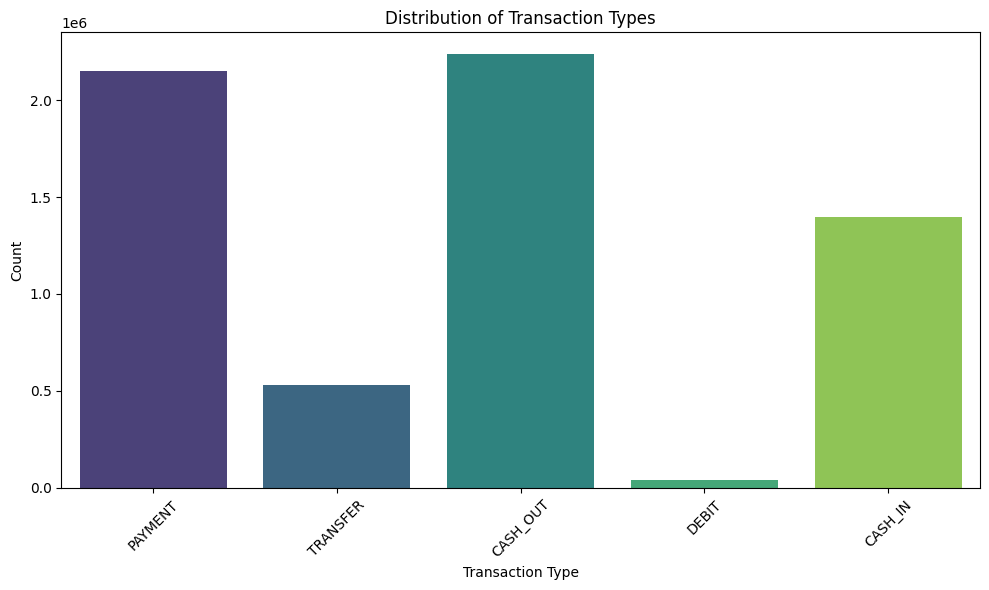

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', palette='viridis')
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Distribusi Fraud dan Non-Fraud

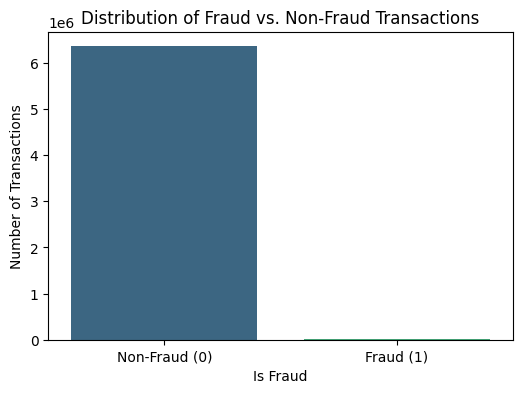

Distribution of 'isFraud' labels:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [ ]:
# Count the occurrences of each 'isFraud' label
fraud_counts = df['isFraud'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
plt.title('Distribution of Fraud vs. Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

print("Distribution of 'isFraud' labels:")
print(fraud_counts)

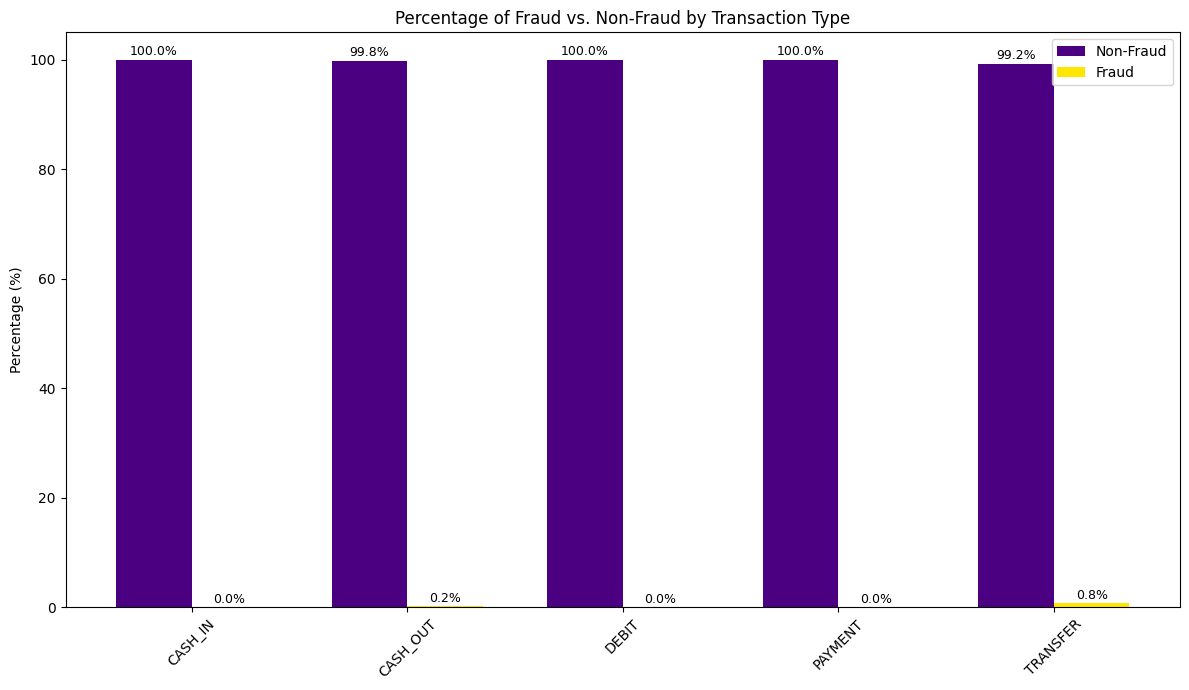

In [ ]:
df_pivot = df.groupby('type')['isFraud'].value_counts(normalize=True).mul(100).unstack().fillna(0)
df_pivot = df_pivot[[0, 1]]  # non-fraud dulu, fraud kemudian

fig, ax = plt.subplots(figsize=(12,7))

# Bar positions
x = np.arange(len(df_pivot.index))
width = 0.35

# Plot grouped bar
bars1 = ax.bar(x - width/2, df_pivot[0], width, label="Non-Fraud", color='#4b0082')
bars2 = ax.bar(x + width/2, df_pivot[1], width, label="Fraud", color='#ffe600')

# Labels & formatting
ax.set_title("Percentage of Fraud vs. Non-Fraud by Transaction Type")
ax.set_ylabel("Percentage (%)")
ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.legend()

# Add percentage labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.3, f"{height:.1f}%",
            ha='center', va='bottom', fontsize=9, color='black')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.3, f"{height:.1f}%",
            ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


In [ ]:
df_counts = df.groupby('type')['isFraud'].value_counts().unstack().fillna(0)
print("Numerical distribution of 'isFraud' by 'type':")
print(df_counts)

Numerical distribution of 'isFraud' by 'type':
isFraud           0       1
type                       
CASH_IN   1399284.0     0.0
CASH_OUT  2233384.0  4116.0
DEBIT       41432.0     0.0
PAYMENT   2151495.0     0.0
TRANSFER   528812.0  4097.0


## Data Preparation

In [ ]:
df_clean = df.copy()
df_clean.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df_clean.drop(["step", 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
# Drop rows where 'type' is 'DEBIT', 'PAYMENT', or 'CASH_IN'
df_clean = df_clean[~df_clean['type'].isin(['DEBIT', 'PAYMENT', 'CASH_IN'])]
df_clean.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


### Normalisasi Data Numerik Menggunakan RobustScaler

In [ ]:
# Identify numerical columns to normalize (excluding target/flag columns)
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Initialize RobustScaler
scaler = RobustScaler()

# Apply Robust scaling to the selected columns
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

print("Numerical columns normalized successfully using RobustScaler.")
print(df_clean[numerical_cols].head())

Numerical columns normalized successfully using RobustScaler.
      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
2  -0.764372      -0.003967             0.0       -0.345628       -0.461335
3  -0.764372      -0.003967             0.0       -0.332454       -0.461335
15  0.258572       0.484597             0.0       -0.342467       -0.432635
19  0.196809       0.012938             0.0       -0.331681       -0.461335
24  0.627408       0.339744             0.0       -0.341730        1.053601


### Melakukan One-Hot Encoding pada data Type

In [ ]:
# Perform one-hot encoding on the 'type' column
df_clean = pd.get_dummies(df_clean, columns=['type'], prefix='type', drop_first=True)

print("One-hot encoding applied to 'type' column successfully.")
print(df_clean.head())

# Note: 'nameOrig' and 'nameDest' columns are not one-hot encoded
# due to their very high cardinality (too many unique values).
# Encoding them directly would create an extremely sparse DataFrame
# and could lead to memory issues or inefficiency.

One-hot encoding applied to 'type' column successfully.
      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
2  -0.764372      -0.003967             0.0       -0.345628       -0.461335   
3  -0.764372      -0.003967             0.0       -0.332454       -0.461335   
15  0.258572       0.484597             0.0       -0.342467       -0.432635   
19  0.196809       0.012938             0.0       -0.331681       -0.461335   
24  0.627408       0.339744             0.0       -0.341730        1.053601   

    isFraud  type_TRANSFER  
2         1           True  
3         1          False  
15        0          False  
19        0           True  
24        0           True  


### UnderSample

In [ ]:
def undersample_majority(df, target, new_size):
    majority = df[df[target] == 0]
    minority = df[df[target] == 1]

    # Ambil sample majority
    majority_sample = resample(
        majority,
        replace=False,
        n_samples=new_size,
        random_state=42
    )

    # Data majority yang TIDAK terpilih (sisa)
    majority_remaining = majority.drop(majority_sample.index)

    # Gabungkan sample majority + minority
    df_under = pd.concat([majority_sample, minority]).sample(frac=1, random_state=42)

    # df_clean versi baru setelah sample majority dihapus
    df_remaining = pd.concat([majority_remaining, minority]).sample(frac=1, random_state=42)

    return df_under, df_remaining


In [ ]:
df_under, df_clean = undersample_majority(df_clean, "isFraud", new_size=300000)

print("Dataset hasil undersample:")
print(df_under['isFraud'].value_counts())

print("\nDataset sisa (sudah dibuang sample majority):")
print(df_clean['isFraud'].value_counts())


Dataset hasil undersample:
isFraud
0    300000
1      8213
Name: count, dtype: int64

Dataset sisa (sudah dibuang sample majority):
isFraud
0    2462196
1       8213
Name: count, dtype: int64


### Random oversampling

In [ ]:
def random_oversample(df, target_column, ratio=10):
    # Pisahkan majority dan minority
    majority_class = df_under[df_under[target_column] == df_under[target_column].mode()[0]]
    minority_class = df_under[df_under[target_column] != df_under[target_column].mode()[0]]

    # Hitung target oversampling
    target_minority = len(majority_class) // ratio

    # Oversample minority
    minority_oversampled = resample(
        minority_class,
        replace=True,
        n_samples=target_minority,
        random_state=42
    )

    # Gabungkan kembali
    df_balanced = pd.concat([majority_class, minority_oversampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42)

    return df_balanced

In [ ]:
df_balanced = random_oversample(df_under, 'isFraud', ratio=10)
df_balanced['isFraud'].value_counts()

isFraud
0    300000
1     30000
Name: count, dtype: int64

### Split Data

In [ ]:
df_clean.to_csv('data.csv', index=False)

In [ ]:
df_balanced.to_csv('data.csv', index=False)

In [ ]:
X = df_balanced.drop('isFraud', axis=1)
y = df_balanced['isFraud']

print("Features (X) and target (y) separated successfully.")
print("X shape:", X.shape)
print("y shape:", y.shape)

Features (X) and target (y) separated successfully.
X shape: (330000, 6)
y shape: (330000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset split into training and testing sets successfully.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Dataset split into training and testing sets successfully.
X_train shape: (264000, 6)
X_test shape: (66000, 6)
y_train shape: (264000,)
y_test shape: (66000,)


## Modelling

### ANN

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("ANN model built successfully.")
model.summary()

I0000 00:00:1763477474.182483     118 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


ANN model built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

print("Model training completed.")

Epoch 1/5
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9936 - loss: 0.1286 - val_accuracy: 0.9953 - val_loss: 0.0211
Epoch 2/5
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9939 - loss: 0.0824 - val_accuracy: 0.9955 - val_loss: 0.0212
Epoch 3/5
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9941 - loss: 0.0243 - val_accuracy: 0.9945 - val_loss: 0.0209
Epoch 4/5
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9938 - loss: 0.0540 - val_accuracy: 0.9935 - val_loss: 0.0224
Epoch 5/5
8250/8250 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9938 - loss: 0.0229 - val_accuracy: 0.9936 - val_loss: 0.0213
Model training completed.


In [ ]:
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.9939
Final Validation Accuracy: 0.9936
Final Training Loss: 0.0229
Final Validation Loss: 0.0213


### XGBoost

In [ ]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, n_jobs=-1) # n_jobs=-1 to use all available cores

print("Training XGBoost model...")
# Train the model
xgb_model.fit(X_train, y_train)
print("XGBoost model training completed.")

# Make predictions on the training set
y_train_pred_xgb = xgb_model.predict(X_train)
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print(f"XGBoost Training Accuracy: {train_accuracy_xgb:.4f}")

# Make predictions on the test set
y_test_pred_xgb = xgb_model.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.4f}")

Training XGBoost model...
XGBoost model training completed.
XGBoost Training Accuracy: 0.9981
XGBoost Test Accuracy: 0.9974


## Evaluation

### ANN

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


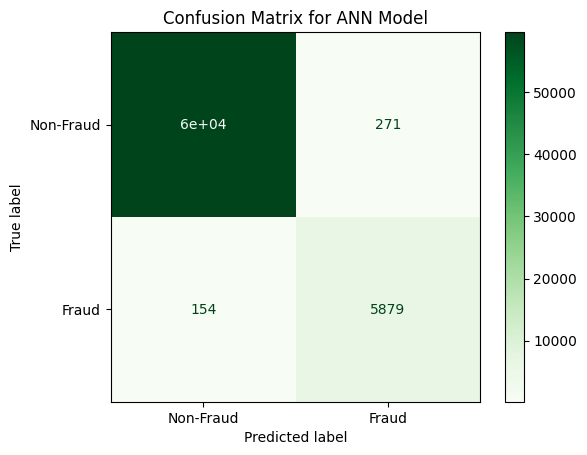

Confusion Matrix for ANN Model:
[[59696   271]
 [  154  5879]]
Accuracy Score for ANN Model: 0.993560606060606
Precision Score for ANN Model: 0.9559349593495935
Recall Score for ANN Model: 0.9744737278302669
F1 Score for ANN Model: 0.9651153246326848


In [ ]:
# Make predictions with the ANN model on the test set
y_pred_ann_prob = model.predict(X_test)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int)

# Generate the confusion matrix for ANN
cm_ann = confusion_matrix(y_test, y_pred_ann)

# Display the confusion matrix for ANN
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=['Non-Fraud', 'Fraud'])
disp_ann.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix for ANN Model')
plt.show()

print("Confusion Matrix for ANN Model:")
print(cm_ann)

ann_accuracy = accuracy_score(y_test, y_pred_ann)
print(f"Accuracy Score for ANN Model: {ann_accuracy}")

ann_precision = precision_score(y_test, y_pred_ann)
print(f"Precision Score for ANN Model: {ann_precision}")

ann_recall = recall_score(y_test, y_pred_ann)
print(f"Recall Score for ANN Model: {ann_recall}")

ann_f1 = f1_score(y_test, y_pred_ann)
print(f"F1 Score for ANN Model: {ann_f1}")

### XGBoost

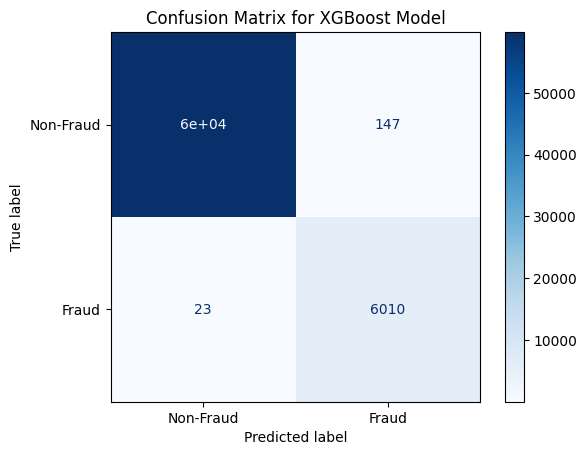

Confusion Matrix for XGBoost Model:
[[59820   147]
 [   23  6010]]
Accuracy Score for XGBoost Model: 0.9974242424242424
Precision Score for XGBoost Model: 0.9761247360727627
Recall Score for XGBoost Model: 0.996187634675949
F1 Score for XGBoost Model: 0.9860541427399507


In [ ]:
# Calculate predictions for the test set (already done, y_test_pred_xgb)

# Generate the confusion matrix
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb, labels=[0, 1]) # Specify labels to ensure order

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

print("Confusion Matrix for XGBoost Model:")
print(cm_xgb)

xgb_accuracy = accuracy_score(y_test, y_test_pred_xgb)
print(f"Accuracy Score for XGBoost Model: {xgb_accuracy}")

xgb_precision = precision_score(y_test, y_test_pred_xgb)
print(f"Precision Score for XGBoost Model: {xgb_precision}")

xgb_recall = recall_score(y_test, y_test_pred_xgb)
print(f"Recall Score for XGBoost Model: {xgb_recall}")

xgb_f1 = f1_score(y_test, y_test_pred_xgb)
print(f"F1 Score for XGBoost Model: {xgb_f1}")

## Inference

In [ ]:
x_inference = df_clean.drop('isFraud', axis=1)
y_inference = df_clean['isFraud']

### ANN

In [ ]:
# Ambil beberapa sampel dari X_test untuk inferensi
num_samples = 10000 # Meningkatkan sampel untuk potensi melihat lebih banyak fraud
X_inference_samples = x_inference.head(num_samples)
y_true_labels = y_inference.head(num_samples)

# Lakukan prediksi menggunakan model
predictions = model.predict(X_inference_samples)

# Konversi probabilitas ke kelas biner (0 atau 1) dengan threshold 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Buat DataFrame untuk menampilkan hasil dengan lebih jelas
results_df = X_inference_samples.copy()
results_df['True Label'] = y_true_labels.values
results_df['Predicted Probability'] = predictions.flatten()
results_df['Predicted Class'] = predicted_classes.flatten()
display(results_df)

# Filter untuk menampilkan hanya transaksi yang diprediksi sebagai fraud
predicted_fraud = results_df[results_df['Predicted Class'] != results_df['True Label']]

if not predicted_fraud.empty:
    print("\n--- data yang salah diprediksi (ANN) ---")
    display(predicted_fraud)
    print("\n--- jumlah data yang salah diprediksi ---")
    display(predicted_fraud['Predicted Class'].count())
else:
    print("\n--- No fraudulent transactions predicted in this sample. ---")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_TRANSFER,True Label,Predicted Probability,Predicted Class
327187,1.534538,3.393652,0.0,0.231828,0.482826,False,0,9.257919e-11,0
5898031,-0.414621,-0.009806,0.0,0.009900,-0.099150,False,0,9.922679e-05,0
143960,2.171845,14.574250,0.0,-0.138753,-0.054723,False,0,1.164547e-15,0
632525,0.759629,0.067718,0.0,-0.345628,-0.271197,False,0,4.944367e-05,0
5592742,-0.557678,-0.009806,0.0,-0.170479,-0.278566,False,0,1.469028e-05,0
...,...,...,...,...,...,...,...,...,...
3078331,-0.407711,-0.009806,0.0,0.054137,-0.058662,False,0,1.096010e-04,0
3786721,0.149109,0.630385,0.0,0.677878,0.569500,False,0,2.844482e-05,0
3146656,-0.697506,-0.009806,0.0,-0.081633,-0.216417,False,0,6.534295e-05,0
1933437,0.879852,0.311128,0.0,-0.288112,-0.204685,True,0,4.074558e-07,0



--- data yang salah diprediksi (ANN) ---


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_TRANSFER,True Label,Predicted Probability,Predicted Class
5493319,-0.459406,2.113319,0.00,-0.293212,-0.376253,False,0,0.722944,1
2478942,-0.262054,3.472531,0.00,0.304680,0.183930,False,0,0.634653,1
5669869,0.582267,9.481370,0.00,-0.264523,-0.220662,False,0,0.771345,1
475109,-0.278247,3.420268,0.00,-0.127005,-0.204780,False,0,0.837532,1
5630556,-0.666370,0.660968,0.00,-0.265829,-0.377532,False,0,0.759577,1
1765877,0.654786,10.080299,0.00,-0.345628,-0.284271,False,0,0.965795,1
1058688,-0.696715,0.400301,0.00,-0.298428,-0.410517,False,0,0.511133,1
5700709,0.811296,11.351879,0.00,0.102865,0.136992,False,0,0.997300,1
5227993,-0.555164,1.481629,0.00,-0.163424,-0.271933,False,0,0.883912,1
2930749,-0.656083,0.688390,0.00,-0.260018,-0.371044,False,0,0.544004,1



--- jumlah data yang salah diprediksi ---


47

### XGBoost

In [ ]:
# Ambil beberapa sampel dari X_test untuk inferensi
num_samples = 10000 # Meningkatkan sampel untuk potensi melihat lebih banyak fraud
X_inference_samples_xgb = x_inference.head(num_samples)
y_true_labels_xgb = y_inference.head(num_samples)

# Lakukan prediksi menggunakan model XGBoost
predictions_xgb = xgb_model.predict(X_inference_samples_xgb)

# Buat DataFrame untuk menampilkan hasil dengan lebih jelas
results_df_xgb = X_inference_samples_xgb.copy()
results_df_xgb['True Label'] = y_true_labels_xgb.values
results_df_xgb['Predicted Class'] = predictions_xgb.flatten()
display(results_df_xgb)

# Filter untuk menampilkan hanya transaksi yang diprediksi sebagai fraud
predicted_fraud_xgb = results_df_xgb[results_df_xgb['Predicted Class'] != results_df_xgb['True Label']]

if not predicted_fraud_xgb.empty:
    print("\n--- data yang salah diprediksi (XGBoost) ---")
    display(predicted_fraud_xgb)
    print("\n--- jumlah data yang salah diprediksi ---")
    display(predicted_fraud_xgb['Predicted Class'].count())
else:
    print("\n--- No fraudulent transactions predicted in this sample by XGBoost. ---")

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_TRANSFER,True Label,Predicted Class
327187,1.534538,3.393652,0.0,0.231828,0.482826,False,0,0
5898031,-0.414621,-0.009806,0.0,0.009900,-0.099150,False,0,0
143960,2.171845,14.574250,0.0,-0.138753,-0.054723,False,0,0
632525,0.759629,0.067718,0.0,-0.345628,-0.271197,False,0,0
5592742,-0.557678,-0.009806,0.0,-0.170479,-0.278566,False,0,0
...,...,...,...,...,...,...,...,...
3078331,-0.407711,-0.009806,0.0,0.054137,-0.058662,False,0,0
3786721,0.149109,0.630385,0.0,0.677878,0.569500,False,0,0
3146656,-0.697506,-0.009806,0.0,-0.081633,-0.216417,False,0,0
1933437,0.879852,0.311128,0.0,-0.288112,-0.204685,True,0,0



--- data yang salah diprediksi (XGBoost) ---


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_TRANSFER,True Label,Predicted Class
5493319,-0.459406,2.113319,0.00,-0.293212,-0.376253,False,0,1
5669869,0.582267,9.481370,0.00,-0.264523,-0.220662,False,0,1
1765877,0.654786,10.080299,0.00,-0.345628,-0.284271,False,0,1
5700709,0.811296,11.351879,0.00,0.102865,0.136992,False,0,1
417830,-0.386210,2.647612,0.00,-0.090970,0.049962,False,0,1
585702,-0.764536,-0.005386,0.00,-0.345628,-0.461254,False,0,1
4763046,0.291833,7.577896,0.00,-0.345628,-0.329530,False,0,1
4158308,0.275087,7.202892,0.00,-0.345628,-0.331618,False,0,1
1616533,-0.547061,1.560023,0.00,-0.345628,-0.434136,False,0,1
5755098,0.775681,10.973302,0.00,0.253551,0.267531,False,0,1



--- jumlah data yang salah diprediksi ---


25

### Perbedaan Prediksi ANN dan XGBoost

In [ ]:
num_new_samples = 10000 # Number of new samples to predict
new_unseen_data_preprocessed = x_inference.sample(n=num_new_samples, random_state=88)

# Reconstruct the DataFrame state reflecting the initial data preparation steps (drops and filters)
# but *before* normalization and one-hot encoding.
temp_df_pre_scaling_encoding = df.copy()
temp_df_pre_scaling_encoding.drop(["step", 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
temp_df_pre_scaling_encoding = temp_df_pre_scaling_encoding[~temp_df_pre_scaling_encoding['type'].isin(['DEBIT', 'PAYMENT', 'CASH_IN'])]
original_inference_data_display = temp_df_pre_scaling_encoding.loc[new_unseen_data_preprocessed.index]

print(f"--- Simulating Inference on {num_new_samples} New Samples ---\n")

# --- ANN Model Inference ---
ann_new_predictions_prob = model.predict(new_unseen_data_preprocessed)
ann_new_predicted_classes = (ann_new_predictions_prob > 0.5).astype(int)

# --- XGBoost Model Inference ---
xgb_new_predicted_classes = xgb_model.predict(new_unseen_data_preprocessed)

# Combine the original format data with the prediction results for a comprehensive display
inference_results_df_with_predictions = original_inference_data_display.copy()
inference_results_df_with_predictions['ANN_Predicted_Probability'] = ann_new_predictions_prob.flatten()
inference_results_df_with_predictions['ANN_Predicted_Class'] = ann_new_predicted_classes.flatten()
inference_results_df_with_predictions['XGBoost_Predicted_Class'] = xgb_new_predicted_classes.flatten()

print("\n--- Hasil Inferensi---\n")
display(inference_results_df_with_predictions)


predicted = inference_results_df_with_predictions[inference_results_df_with_predictions['ANN_Predicted_Class'] != inference_results_df_with_predictions['XGBoost_Predicted_Class']]

if not predicted.empty:
    print("\n--- Predicted ANN vs Predicted XGB ---")
    display(predicted)
    print("\n--- Jumlah data yang berbeda ---")
    display(predicted['ANN_Predicted_Class'].count())
else:
    print('---not table---')

--- Simulating Inference on 10000 New Samples ---

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Hasil Inferensi---



,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,ANN_Predicted_Probability,ANN_Predicted_Class,XGBoost_Predicted_Class
2951936,CASH_OUT,149117.07,20041.00,0.00,645096.37,794213.44,0,3.537723e-05,0,0
336365,CASH_OUT,48785.29,81697.00,32911.71,2457648.85,2506434.14,0,1.639195e-02,0,0
5755485,CASH_OUT,383330.78,7313.78,0.00,3955365.11,4338695.88,0,4.432881e-07,0,0
2712002,CASH_OUT,87059.35,113537.00,26477.65,45321.17,328193.62,0,1.639195e-02,0,0
6120312,CASH_OUT,12611.17,14459.00,1847.83,179342.42,191953.59,0,1.639195e-02,0,0
...,...,...,...,...,...,...,...,...,...,...
3006804,CASH_OUT,101046.02,120763.00,19716.98,0.00,101046.02,0,1.639195e-02,0,0
1502558,CASH_OUT,97170.68,0.00,0.00,9619854.29,9717024.97,0,1.573917e-12,0,0
2998540,CASH_OUT,56812.47,18479.00,0.00,127646.92,184459.39,0,1.918740e-05,0,0
5280979,CASH_OUT,339218.62,11470.00,0.00,3699489.25,4038707.87,0,1.924628e-06,0,0



--- Predicted ANN vs Predicted XGB ---


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,ANN_Predicted_Probability,ANN_Predicted_Class,XGBoost_Predicted_Class
3496981,CASH_OUT,7545.21,5188.00,0.00,323521.59,54602.39,0,0.750397,1,0
618375,CASH_OUT,462699.60,439894.64,0.00,7530849.52,7993549.12,0,0.072818,0,1
1014494,CASH_OUT,52490.59,51691.00,0.00,2896450.35,2948940.94,0,0.820814,1,0
5073943,CASH_OUT,90053.00,85821.00,0.00,1544823.97,1634876.97,0,0.654655,1,0
828689,CASH_OUT,230956.43,28.00,0.00,0.00,230956.43,0,0.001090,0,1
1645422,CASH_OUT,265608.80,254223.00,0.00,0.00,265608.80,0,0.125567,0,1
3759434,CASH_OUT,223831.63,218297.00,0.00,192907.82,416739.45,0,0.722270,1,0
3346847,CASH_OUT,138726.86,138770.00,43.14,877453.48,1016180.33,0,0.000853,0,1
1663920,CASH_OUT,32771.14,30925.00,0.00,130409.88,163181.02,0,0.731727,1,0
6295228,CASH_OUT,3107.93,3005.00,0.00,3285706.79,3288814.72,0,0.398755,0,1



--- Jumlah data yang berbeda ---


41

## Save Model

In [ ]:
model.save('ann_model.keras')
print("ANN model saved successfully as 'ann_model.keras'")

ANN model saved successfully as 'ann_model.keras'


ANN model loaded successfully.

Evaluation of Loaded ANN Model:
  Loss: 0.0213
  Accuracy: 0.9936
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report for Loaded ANN Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59967
           1       0.96      0.97      0.97      6033

    accuracy                           0.99     66000
   macro avg       0.98      0.98      0.98     66000
weighted avg       0.99      0.99      0.99     66000



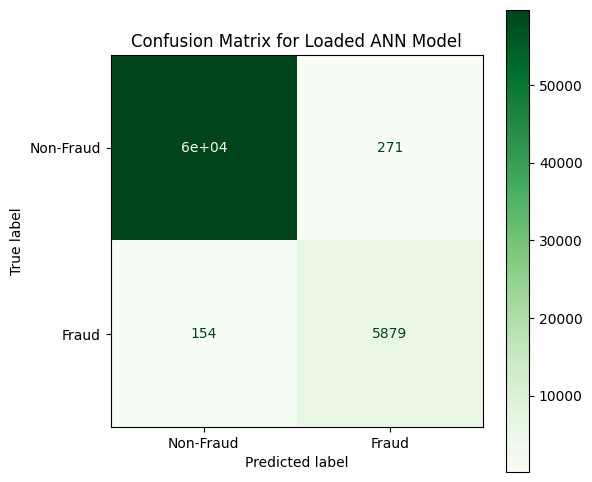

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved ANN model
loaded_ann_model = load_model('ann_model.keras')
print("ANN model loaded successfully.")

# Evaluate the loaded model on the test data
loss, accuracy = loaded_ann_model.evaluate(X_test, y_test, verbose=0)
print(f"\nEvaluation of Loaded ANN Model:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.4f}")

# Make predictions with the loaded ANN model
y_pred_loaded_ann_prob = loaded_ann_model.predict(X_test)
y_pred_loaded_ann = (y_pred_loaded_ann_prob > 0.5).astype(int)

# Generate and display classification metrics
print("\nClassification Report for Loaded ANN Model:")
print(classification_report(y_test, y_pred_loaded_ann))

# Generate and display confusion matrix
cm_loaded_ann = confusion_matrix(y_test, y_pred_loaded_ann)
disp_loaded_ann = ConfusionMatrixDisplay(confusion_matrix=cm_loaded_ann, display_labels=['Non-Fraud', 'Fraud'])
fig, ax = plt.subplots(figsize=(6, 6))
disp_loaded_ann.plot(cmap=plt.cm.Greens, ax=ax)
plt.title('Confusion Matrix for Loaded ANN Model')
plt.show()

In [ ]:
import pickle

# Save the XGBoost model to a .pkl file
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("XGBoost model saved successfully as 'xgboost_model.pkl'")

XGBoost model saved successfully as 'xgboost_model.pkl'


XGBoost model loaded successfully.

Evaluation of Loaded XGBoost Model:
  Accuracy Score: 0.9974
  Precision Score: 0.9761
  Recall Score: 0.9962
  F1 Score: 0.9861


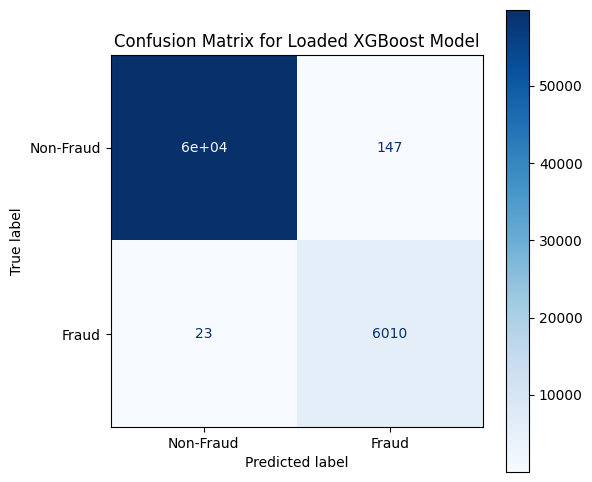

In [ ]:
# Load the saved XGBoost model
with open('xgboost_model.pkl', 'rb') as f:
    loaded_xgb_model = pickle.load(f)

print("XGBoost model loaded successfully.")

# Make predictions on the test set with the loaded model
y_pred_loaded_xgb = loaded_xgb_model.predict(X_test)

# Calculate and print metrics
print("\nEvaluation of Loaded XGBoost Model:")
print(f"  Accuracy Score: {accuracy_score(y_test, y_pred_loaded_xgb):.4f}")
print(f"  Precision Score: {precision_score(y_test, y_pred_loaded_xgb):.4f}")
print(f"  Recall Score: {recall_score(y_test, y_pred_loaded_xgb):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred_loaded_xgb):.4f}")

# Generate and display confusion matrix
cm_loaded_xgb = confusion_matrix(y_test, y_pred_loaded_xgb, labels=[0, 1])
disp_loaded_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_loaded_xgb, display_labels=['Non-Fraud', 'Fraud'])
fig, ax = plt.subplots(figsize=(6, 6))
disp_loaded_xgb.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Loaded XGBoost Model')
plt.show()

In [ ]:
import pickle

# Make sure the 'model' directory exists
os.makedirs('model', exist_ok=True)

# Save the RobustScaler object
with open('model/robust_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("RobustScaler saved successfully as 'model/robust_scaler.pkl'")

RobustScaler saved successfully as 'model/robust_scaler.pkl'
